# Prediction of United States' Counties Poverty Rates
Mark Vervuurt <br>
19-01-2018

## Executive Summary

This document presents the results of the regression analysis to predict poverty rates of United States' Counties. 

A regression model which uses an AdaBoostRegressor was created. This AdaBoostRegressor is able to predict United States' Counties poverty rates with an RMSE of 2.7853. 

| Model           | RMSE 
|:----------------|:------
|AdaBoostRegressor|  2.7853
|Linear Regression|  2.9297

In the data understanding phase was discovered that the following features play a significant role in predicting United States' counties poverty rates. They have moderate positive and negative Pearson correlation coefficients. Futhermore the Boxplots show enough variation and separation of the data with respect to the target variable poverty_rate.

| Significant Features                                | Short Description
|:----------------------------------------------------|:---------
| area__rucc                                          | Rural urban continuum code of county
| econ__economic_typology                             | economic dependence type of county
| aui_pct65y_cat                                      | created categorical feature combining 'area__urban_influence' \n and categorical percentage of 65 years old per county
| demo__pct_adults_less_than_a_high_school_diploma    | percentage of adults with less than high school diploma per county
| health__homicides_per_100k                          | homocides per 100k inhabitants per county
| econ__pct_unemployment                              | percentage of unemployement per county
| health__pct_low_birthweight                         | percentage of low birth weight per county
| econ__pct_uninsured_adults                          | percentage of uninsured adults per county
| health__pct_diabetes                                | percentage of diabetes per county
| demo__pct_non_hispanic_african_american             | percentage of african americans per county
| econ__pct_civilian_labor                            | percentage of civilan labor per county

The CRISP-DM Methodology was used in order to create an accurate regression model:

- __Business Understanding__: read through the '[Rural Poverty & Well-being](https://www.ers.usda.gov/topics/rural-economy-population/rural-poverty-well-being/poverty-overview.aspx)' report to better understand the circumstances of poverty.
- __Data Understanding__: explore the quantitative and categorical variables that play a key role in predicting poverty rates. 
- __Data Preparation__: drop redundant and uninformative features, fill missing values, etc.
- __Modeling__: create and select the best regression model.
- __Evaluation__: evaluate the regression models using nested cross validation.
- __Deployment__: the deployment of the regression model is not strictly applicable here. However presenting the results of the regression analysis with this report can be considered as the deployment step.

## Business Understanding
As described in the online report the '[Rural Poverty & Well-being](https://www.ers.usda.gov/topics/rural-economy-population/rural-poverty-well-being/poverty-overview.aspx)': "Concentrated poverty contributes to poor housing and health conditions, higher crime and school dropout rates, as well as employment dislocations". With this information the data will be explored to see how health, crime,education and employement related factors contribute to poverty.

Another important feature of poverty is time. An area that doesn't have a high level of poverty in two following years is likely better off than an area that has a high level of poverty in both years. It will not be possible to construct a feature with this information because we cannot compare the state's poverty rate over year 'a' and 'b' within this data set. We dont have a unique key to identify counties.

Counties are generally compared by their Non-Metro and Metro status. There is more poverty in Non-Metro areas than Metro areas. Poverty is also higher under certain ages and etnicities. Here also the data will be explored on the basis of this information.

In [65]:
import re
import bs4
import time
import plyfile
import html5lib
import multiprocessing
import itertools

import numpy as np
import pandas as pd

import seaborn as sns
from scipy import misc
import scipy.io.wavfile as wavfile

import scipy
from math import sqrt
from scipy import stats
from pprint import pprint
from sklearn import tree
from sklearn.svm import SVC
from sklearn import manifold
from tempfile import mkdtemp
from textwrap import wrap
from matplotlib import cm as cm

import sklearn.metrics as metrics
from pandas.plotting import scatter_matrix
from scipy.stats import randint as sp_randint
from sklearn.pipeline import TransformerMixin
from sklearn.metrics.scorer import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Binarizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFECV, SelectFromModel, f_regression, SelectKBest
from sklearn.ensemble import RandomForestClassifier, AdaBoostRegressor, AdaBoostClassifier
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Lasso, Ridge
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, Normalizer, RobustScaler, StandardScaler
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix, roc_curve, roc_auc_score, mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_validate, cross_val_predict, KFold, ShuffleSplit, StratifiedShuffleSplit

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm as cm
from mpl_toolkits.mplot3d import Axes3D
from pandas.plotting import parallel_coordinates, andrews_curves

%matplotlib inline
matplotlib.style.use('ggplot')

pd.set_option('display.max_columns', None)

## Data Understanding
In order to build this regression model and determine its most significant features a thorough data exploration was done to understand the relationship between poverty rates and other features.
### Initial Data Exploration
The dataset consists of 3198 records about United States' counties. Each record contains socioeconomic indicators about a United States' county for a given year. Besides the 'row_id', 'yr' and the target value 'poverty_rate', the dataset contains 32 features about socioeconomic indicators.

In [66]:
poverty_train = pd.read_csv('./Microsoft_-_DAT102x_Predicting_Poverty_in_the_United_States_-_Training_values.csv')

In [67]:
poverty_train.shape

(3198, 34)

In [68]:
poverty_train.dtypes

row_id                                                int64
area__rucc                                           object
area__urban_influence                                object
econ__economic_typology                              object
econ__pct_civilian_labor                            float64
econ__pct_unemployment                              float64
econ__pct_uninsured_adults                          float64
econ__pct_uninsured_children                        float64
demo__pct_female                                    float64
demo__pct_below_18_years_of_age                     float64
demo__pct_aged_65_years_and_older                   float64
demo__pct_hispanic                                  float64
demo__pct_non_hispanic_african_american             float64
demo__pct_non_hispanic_white                        float64
demo__pct_american_indian_or_alaskan_native         float64
demo__pct_asian                                     float64
demo__pct_adults_less_than_a_high_school

#### Individual Feature Statistics
Here are the summary statistics for all the socioeconomic features:
- summary statistics of categorical variables: the total count (count), number of unique elements (unique), most frequent element (top) and the frequency of the most frequent element (frequent)
- summary statistics of quantitative variables: the mean, the standard deviation (std), the minimum value (min), 25% percentile, 50% percentile (median), 75% percentile and the maximum value (max).

In [69]:
poverty_train.drop(columns=['row_id'], axis=1).describe(include='all')

area__rucc  \
count                                                3198   
unique                                                  9   
top     Nonmetro - Urban population of 2,500 to 19,999...   
freq                                                  608   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

                                    area__urban_influence  \
count                                                3198   
unique                                                 12   
top     Small-in a metro area with fewer than 1 millio...   
freq                                                  692   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

       econ__economic_typology  econ__pct_civilian_labor  \
count                     3198               3198.000000   
unique                       6                       NaN   
top             Nonspecialized                       NaN   
freq                      1266                       NaN   
mean                       NaN                  0.467071   
std                        NaN                  0.074541   
min                        NaN                  0.217000   
25%                        NaN                  0.420000   
50%                        NaN                  0.467000   
75%                        NaN                  0.514000   
max                        NaN                  1.000000   

        econ__pct_unemployment  econ__pct_uninsured_adults  \
count               3198.00000                 3196.000000   
unique                     NaN                         NaN   
top                        NaN                         NaN   
freq                       NaN                         NaN   
mean                   0.05961                    0.217534   
std                    0.02285                    0.067372   
min                    0.00800                    0.046000   
25%                    0.04400                    0.166000   
50%                    0.05700                    0.216000   
75%                    0.07100                    0.262000   
max                    0.24000                    0.495000   

        econ__pct_uninsured_children  demo__pct_female  \
count                    3196.000000       3196.000000   
unique                           NaN               NaN   
top                              NaN               NaN   
freq                             NaN               NaN   
mean                        0.085920          0.498781   
std                         0.040005          0.024251   
min                         0.009000          0.294000   
25%                         0.057000          0.493000   
50%                         0.077000          0.503000   
75%                         0.105000          0.512000   
max                         0.285000          0.576000   

        demo__pct_below_18_years_of_age  demo__pct_aged_65_years_and_older  \
count                       3196.000000                        3196.000000   
unique                              NaN                                NaN   
top                                 NaN                                NaN   
freq                                NaN                                NaN   
mean                        

In [70]:
poverty_labels = pd.read_csv('Microsoft_-_DAT102x_Predicting_Poverty_in_the_United_States_-_Training_labels.csv')

In [71]:
poverty_labels.shape

(3198, 2)

In [72]:
poverty_labels.dtypes

row_id            int64
poverty_rate    float64
dtype: object

Here are the summary statistics for the target variable which is quantitative:

In [73]:
poverty_labels.drop(columns=['row_id'], axis=1).describe()

poverty_rate
count   3198.000000
mean      16.817136
std        6.697969
min        2.500000
25%       12.000000
50%       15.800000
75%       20.300000
max       47.400000

Poverty rates are right or positively skewed with a skew value of 1.048357. We can recognize a slight bell curve in the data. The mean and median are relatively close to each other and the standard deviation is relatively low which indicates low variability in the poverty rates. Most United States' counties have a poverty_rate between 10% and 20% poverty.

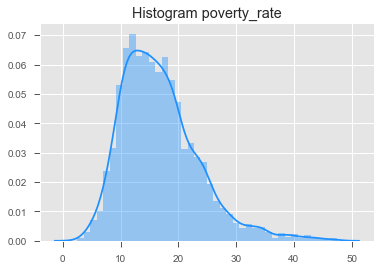

In [74]:
ht_pov = sns.distplot(poverty_labels.drop(columns=['row_id'], axis=1), color='dodgerblue').set_title('Histogram poverty_rate')

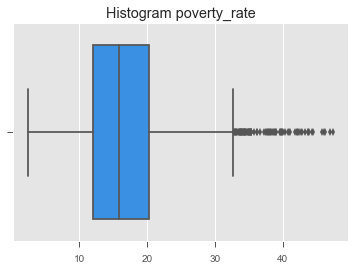

In [75]:
ht_pov = sns.boxplot(poverty_labels.drop(columns=['row_id'], axis=1), color='dodgerblue').set_title('Histogram poverty_rate')

In [76]:
poverty = pd.merge(poverty_train, poverty_labels, on='row_id')
poverty.shape

(3198, 35)

From the summary statistics above, should be clear that there are three categorical variables included in the dataset:
- area__rucc with 9 values: 
 - 'Nonmetro - Urban population of 2,500 to 19,999, adjacent to a metro area' counties are most frequent with 608 counties.
 - 'Nonmetro - Urban population of 20,000 or more, not adjacent to a metro area' counties are most infrequent with 100 counties.
- area__urban_influence	with 12 values: 
 - 'Small-in a metro area with fewer than 1 million residents' counties are most frequent with 692 counties.
 - 'Noncore not adjacent to a metro/micro area and contains a town of 2,500  or more residents' counties are most infrequent with 122.
- econ__economic_typology with 6 values: 
 - 'Non specialized' economic typology counties are most frequent with 1266 counties. 
 - 'Mining-dependent' economic typologpy counties are most infrequent with 254 counties.
 
Here under the barplots speak for themselves.

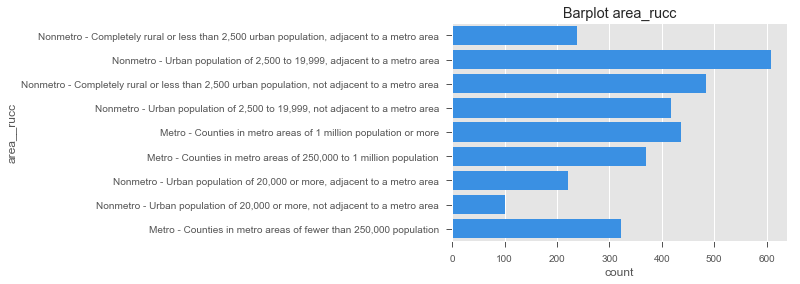

In [77]:
bh_ar = sns.countplot(y='area__rucc', data=poverty, color='dodgerblue').set_title("Barplot area_rucc")

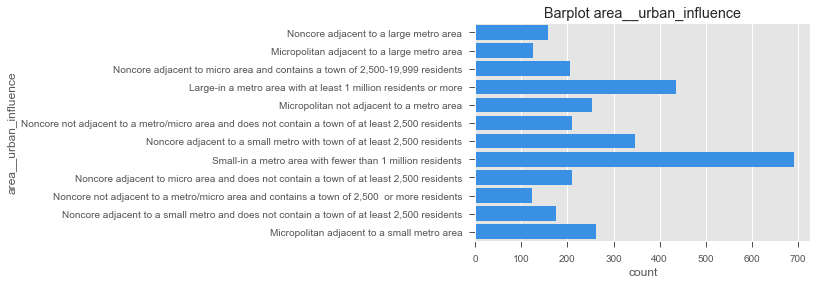

In [78]:
bh_aui = sns.countplot(y='area__urban_influence', data=poverty, color='dodgerblue').set_title("Barplot area__urban_influence")

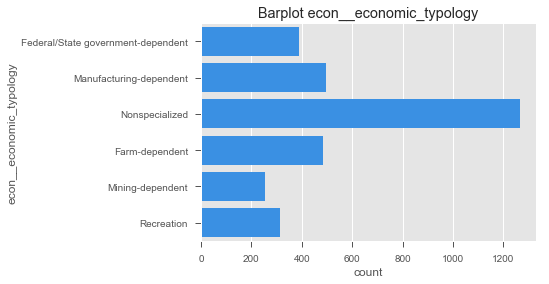

In [79]:
bh_eet = sns.countplot(y='econ__economic_typology', data=poverty, color='dodgerblue').set_title("Barplot econ__economic_typology")

### Data Exploration and Visualization of Categorical Variables
Here the predictive value of the categorical variables 'econ\_\_economic\_typology', 'area\_\_urban\_influence', 'area\_\_rucc' and 'yr' is explored. Boxplots are used to explore these categorical variables.

The boxplots of the categorical variables 'econ\_\_economic\_typology', 'area\_\_urban\_influence' and 'area\_\_rucc' show interesting variation:
* 'Farm-dependent' counties have the lowest poverty rates and 'Federal/State government-dependent' counties have the highest poverty rates.
* 'Large-in a metro area with at least 1 million residents or more' counties have the lowest poverty rates.
* 'Metro - Counties in metro areas with 1 million population or more' counties have the lowest poverty rates.

Furthermore by combining features more interesting categorical variables can be created explaining much more of the variance in poverty rates.
* 'demo\_\_pct\_aged\_65\_years\_and\_older' and 'area\_\_urban\_influence'. The general trend is that counties with a low percentage population of "65 years or older" have a higher poverty rate.

The difference in poverty over year 'a' and 'b' is really minimal. Furthermore it doesn't make sense to use this feature to predict poverty rates. This feature will be droped at the cleaning stage.

In [80]:
bpd_ar = sns.boxplot(orient="h", x='poverty_rate', y='area__rucc', hue='poverty_rate_cat', data=poverty, color='dodgerblue').set_title('Boxplot poverty_rate by area_rucc')

ValueError: Could not interpret input 'poverty_rate_cat'

In [ ]:
bpd_eet = sns.boxplot(orient="h", x='poverty_rate', y='econ__economic_typology', hue='poverty_rate_cat', data=poverty, color='dodgerblue').set_title('Boxplot poverty_rate by econ__economic_typology')

In [81]:
def create_old_age_cat(input_df):
    low_pct_olds = poverty.demo__pct_aged_65_years_and_older < 0.167000
    high_pct_olds = poverty.demo__pct_aged_65_years_and_older >= 0.167000
    input_df.loc[low_pct_olds,'pct_65years_cat'] = 'low_pct_65years'
    input_df.loc[high_pct_olds,'pct_65years_cat'] = 'high_pct_65years'
    
    age_old_cats = ['low_pct_65years','high_pct_65years']
    input_df.loc[:,'pct_65years_cat'] = input_df.pct_65years_cat.astype('category')
    input_df.loc[:,'pct_65years_cat'] = input_df.pct_65years_cat.cat.set_categories(age_old_cats, ordered=True)
    return input_df

In [82]:
poverty = create_old_age_cat(poverty)

In [83]:
def create_aui_pct65y_cat(input_df):
    aui_cats = input_df.area__urban_influence.unique()
    pct65y_cats = input_df.pct_65years_cat.cat.categories
    
    aui_pct65y_masks = [ ((input_df.area__urban_influence == aui) & (input_df.pct_65years_cat == pct65y)
                          , aui + ', ' + pct65y) 
                        for (aui, pct65y) in list(itertools.product(aui_cats, pct65y_cats))]

    aui_pct65y_lbls = [aui + ', ' + pct65y for (aui, pct65y)  
                    in list(itertools.product(aui_cats, pct65y_cats))]
      
    for mask, aui_pct65y_lb in aui_pct65y_masks:
        input_df.loc[mask, 'aui_pct65y_cat'] = aui_pct65y_lb
        
    input_df.loc[:,'aui_pct65y_cat'] = input_df.aui_pct65y_cat.astype('category')
    input_df.loc[:,'aui_pct65y_cat'] = input_df.aui_pct65y_cat.cat.set_categories(aui_pct65y_lbls)
    return input_df

In [84]:
poverty = create_aui_pct65y_cat(poverty)
plt.figure(figsize=(10,10))
bpd_eet = sns.boxplot(orient="h", x='poverty_rate', y='aui_pct65y_cat', hue='poverty_rate_cat', data=poverty, color='dodgerblue').set_title('Boxplot poverty_rate by area__urban_influence \n and categorical percentage 65 years old')

ValueError: Could not interpret input 'poverty_rate_cat'

### Data Exploration and Visualization of Quantitative Variables
For the quantitative variables the correlation matrix is computed first followed by the visual display of the scatterplot matrices.

#### Correlation matrix
The strongest correlations observed are moderate positive and negative for the following features:
- demo__pct_adults_less_than_a_high_school_diploma    
- health__homicides_per_100k                          
- econ__pct_unemployment                              
- health__pct_low_birthweight                         
- econ__pct_uninsured_adults                          
- health__pct_diabetes                                
- demo__pct_non_hispanic_african_american             
- econ__pct_civilian_labor                            

The whole correlation matrix of interest is shown here under.

| Features                                            | Pearson Correlation Coefficient
|:----------------------------------------------------|---------
| econ__pct_civilian_labor                            | -0.670417
| demo__pct_non_hispanic_white                        | -0.499974
| demo__pct_adults_bachelors_or_higher                | -0.467134
| demo__pct_adults_with_some_college                  | -0.363875
| health__pct_excessive_drinking                      | -0.353254
| demo__pct_asian                                     | -0.163033
| demo__pct_aged_65_years_and_older                   | -0.088123
| demo__pct_female                                    | -0.068065
| demo__pct_below_18_years_of_age                     |  0.039237
| health__air_pollution_particulate_matter            |  0.058582
| econ__pct_uninsured_children                        |  0.098882
| demo__pct_hispanic                                  |  0.105574
| demo__birth_rate_per_1k                             |  0.127506
| health__pop_per_primary_care_physician              |  0.156942
| demo__pct_adults_with_high_school_diploma           |  0.202928
| demo__pct_american_indian_or_alaskan_native         |  0.236508
| demo__death_rate_per_1k                             |  0.244093
| health__pop_per_dentist                             |  0.268996
| health__pct_adult_smoking                           |  0.395457
| health__motor_vehicle_crash_deaths_per_100k         |  0.420348
| health__pct_physical_inacticity                     |  0.437680
| health__pct_adult_obesity                           |  0.444293
| demo__pct_non_hispanic_african_american             |  0.507048
| health__pct_diabetes                                |  0.537038
| econ__pct_uninsured_adults                          |  0.541712
| health__pct_low_birthweight                         |  0.565456
| econ__pct_unemployment                              |  0.592022
| health__homicides_per_100k                          |  0.621399
| demo__pct_adults_less_than_a_high_school_diploma    |  0.680360

#### Scatter plot matrices
After reading the '[Rural Poverty & Well-being](https://www.ers.usda.gov/topics/rural-economy-population/rural-poverty-well-being/poverty-overview.aspx)' report it is clear that education, ethnicity and health related issues play an important role in predicting poverty. In this dataset are also added economic indicators of United States' counties. The scatterplot matrices of these four groups of socioeconomic indicators are shown here under. The scatter plot matrices visually confirms the finding of the correlation matrix.

NB: linear statistical transformations (sqrt, square, exponential, etc) were also applied to the target variable 'poverty_rate' but they did not improve substantially the correlation coefficients and the scatterplot matrices.

The correlation matrices and scatterplot matrices visually confirm that the variables correlate moderatly strong with the target variable 'poverty_rate' seem to have a linear relationship.

In [85]:
def create_poverty_rate_cat(input_df):
    low_pct_olds = poverty.poverty_rate < 33
    high_pct_olds = poverty.poverty_rate >= 33 
    input_df.loc[low_pct_olds,'poverty_rate_cat'] = 'normal_pov_rates'
    input_df.loc[high_pct_olds,'poverty_rate_cat'] = 'outlier_pov_rates'
    
    pov_rates_cats = ['normal_pov_rates','outlier_pov_rates']
    input_df.loc[:,'poverty_rate_cat'] = input_df.poverty_rate_cat.astype('category')
    input_df.loc[:,'poverty_rate_cat'] = input_df.poverty_rate_cat.cat.set_categories(pov_rates_cats, ordered=True)
    return input_df

In [86]:
poverty = create_poverty_rate_cat(poverty)

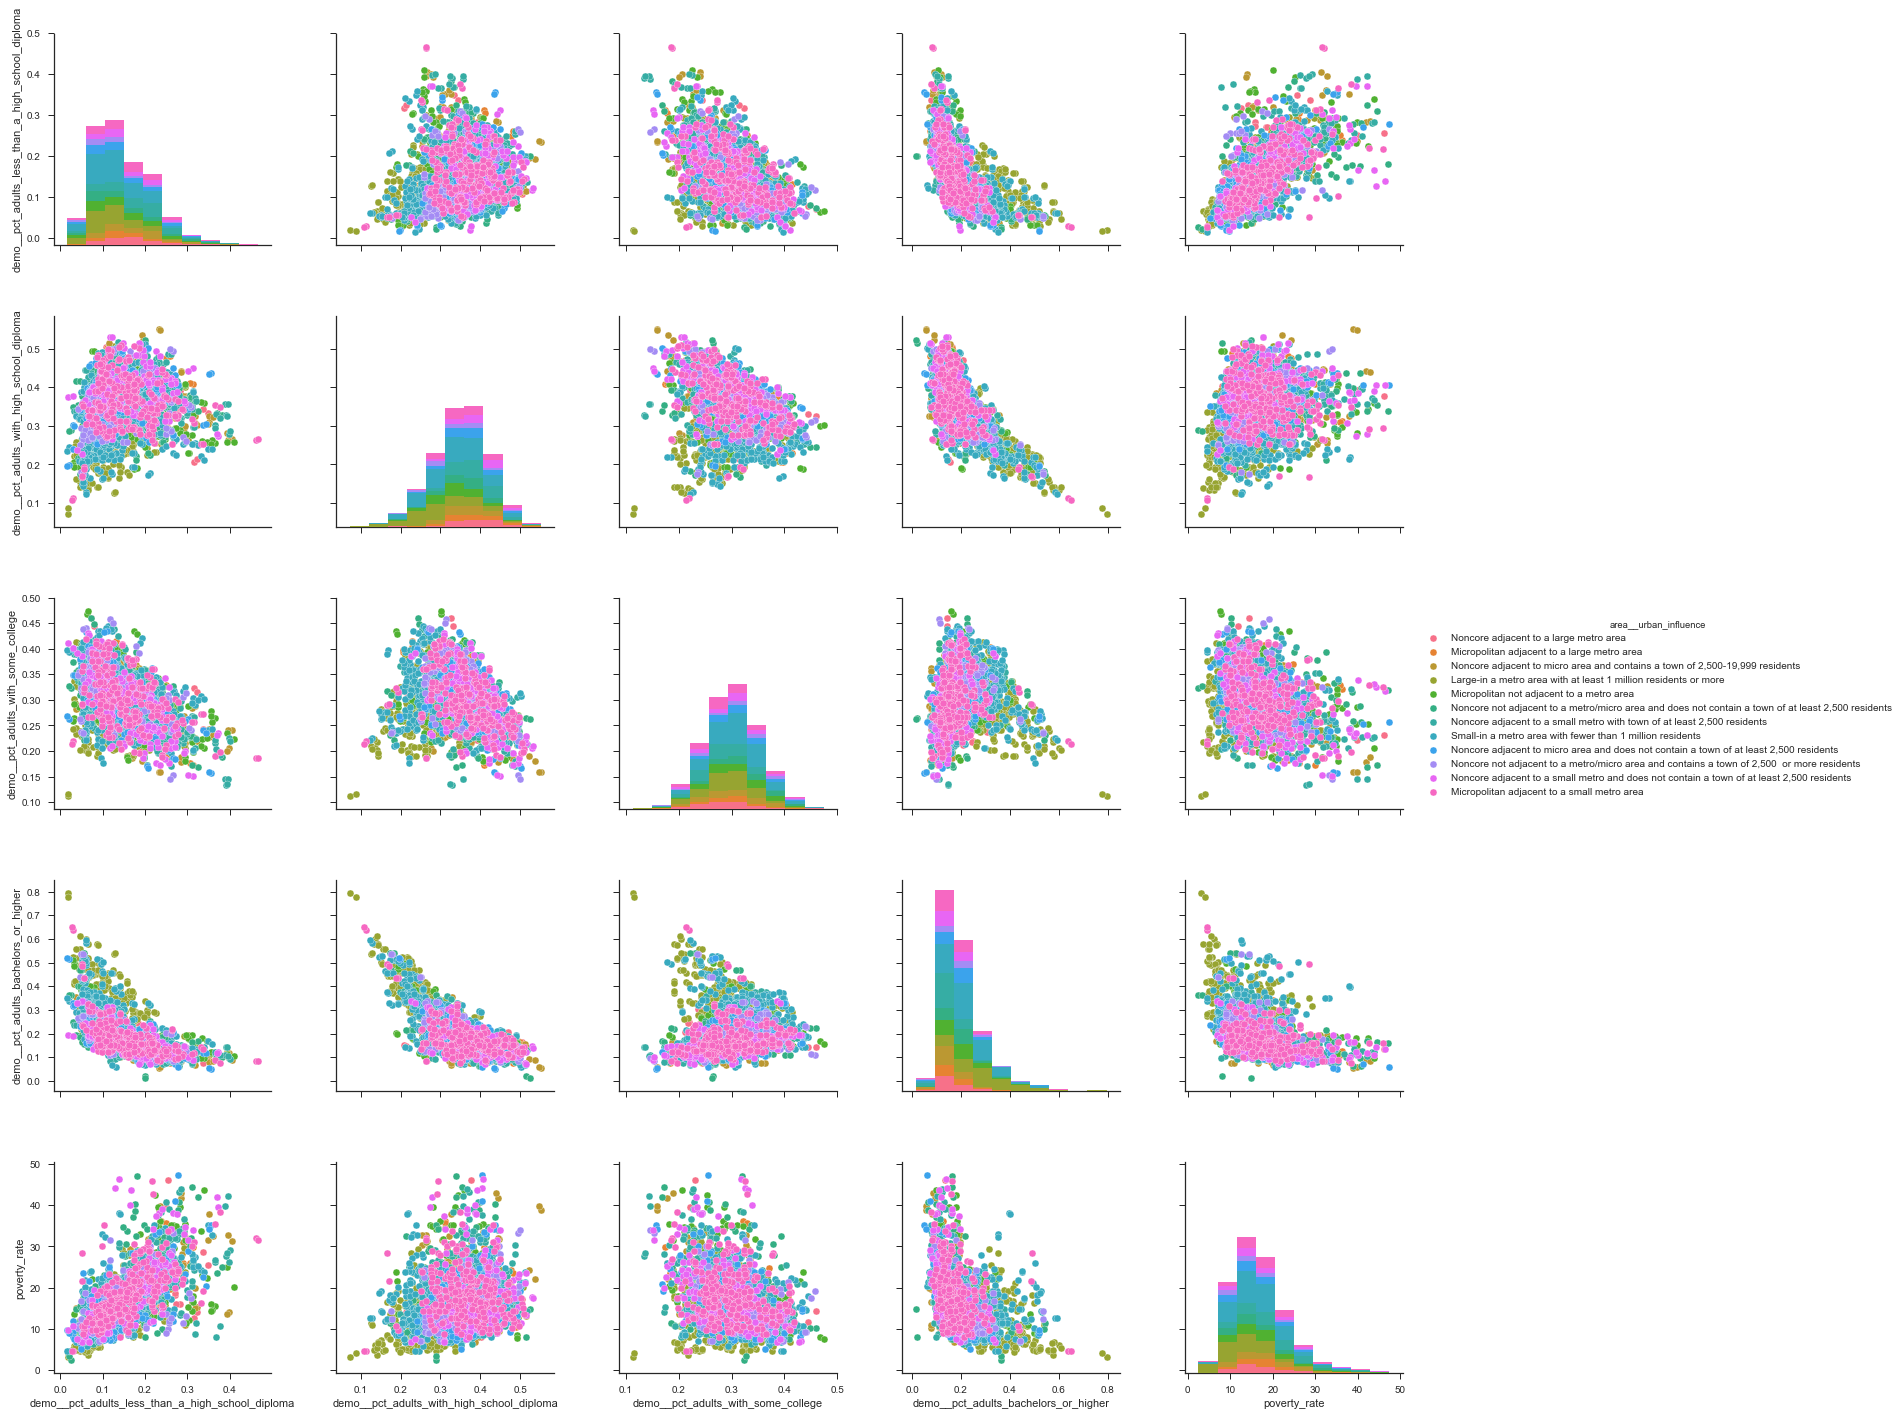

In [146]:
sns.set(style="ticks")
scatter_educ = sns.pairplot(poverty.loc[:, ['demo__pct_adults_less_than_a_high_school_diploma'
                                              ,'demo__pct_adults_with_high_school_diploma','demo__pct_adults_with_some_college'
                                              ,'demo__pct_adults_bachelors_or_higher'
                                              ,'poverty_rate','poverty_rate_cat'
                                              ,'econ__economic_typology', 'area__urban_influence', 'area__rucc']].dropna()
                            , size=4, hue='area__urban_influence')

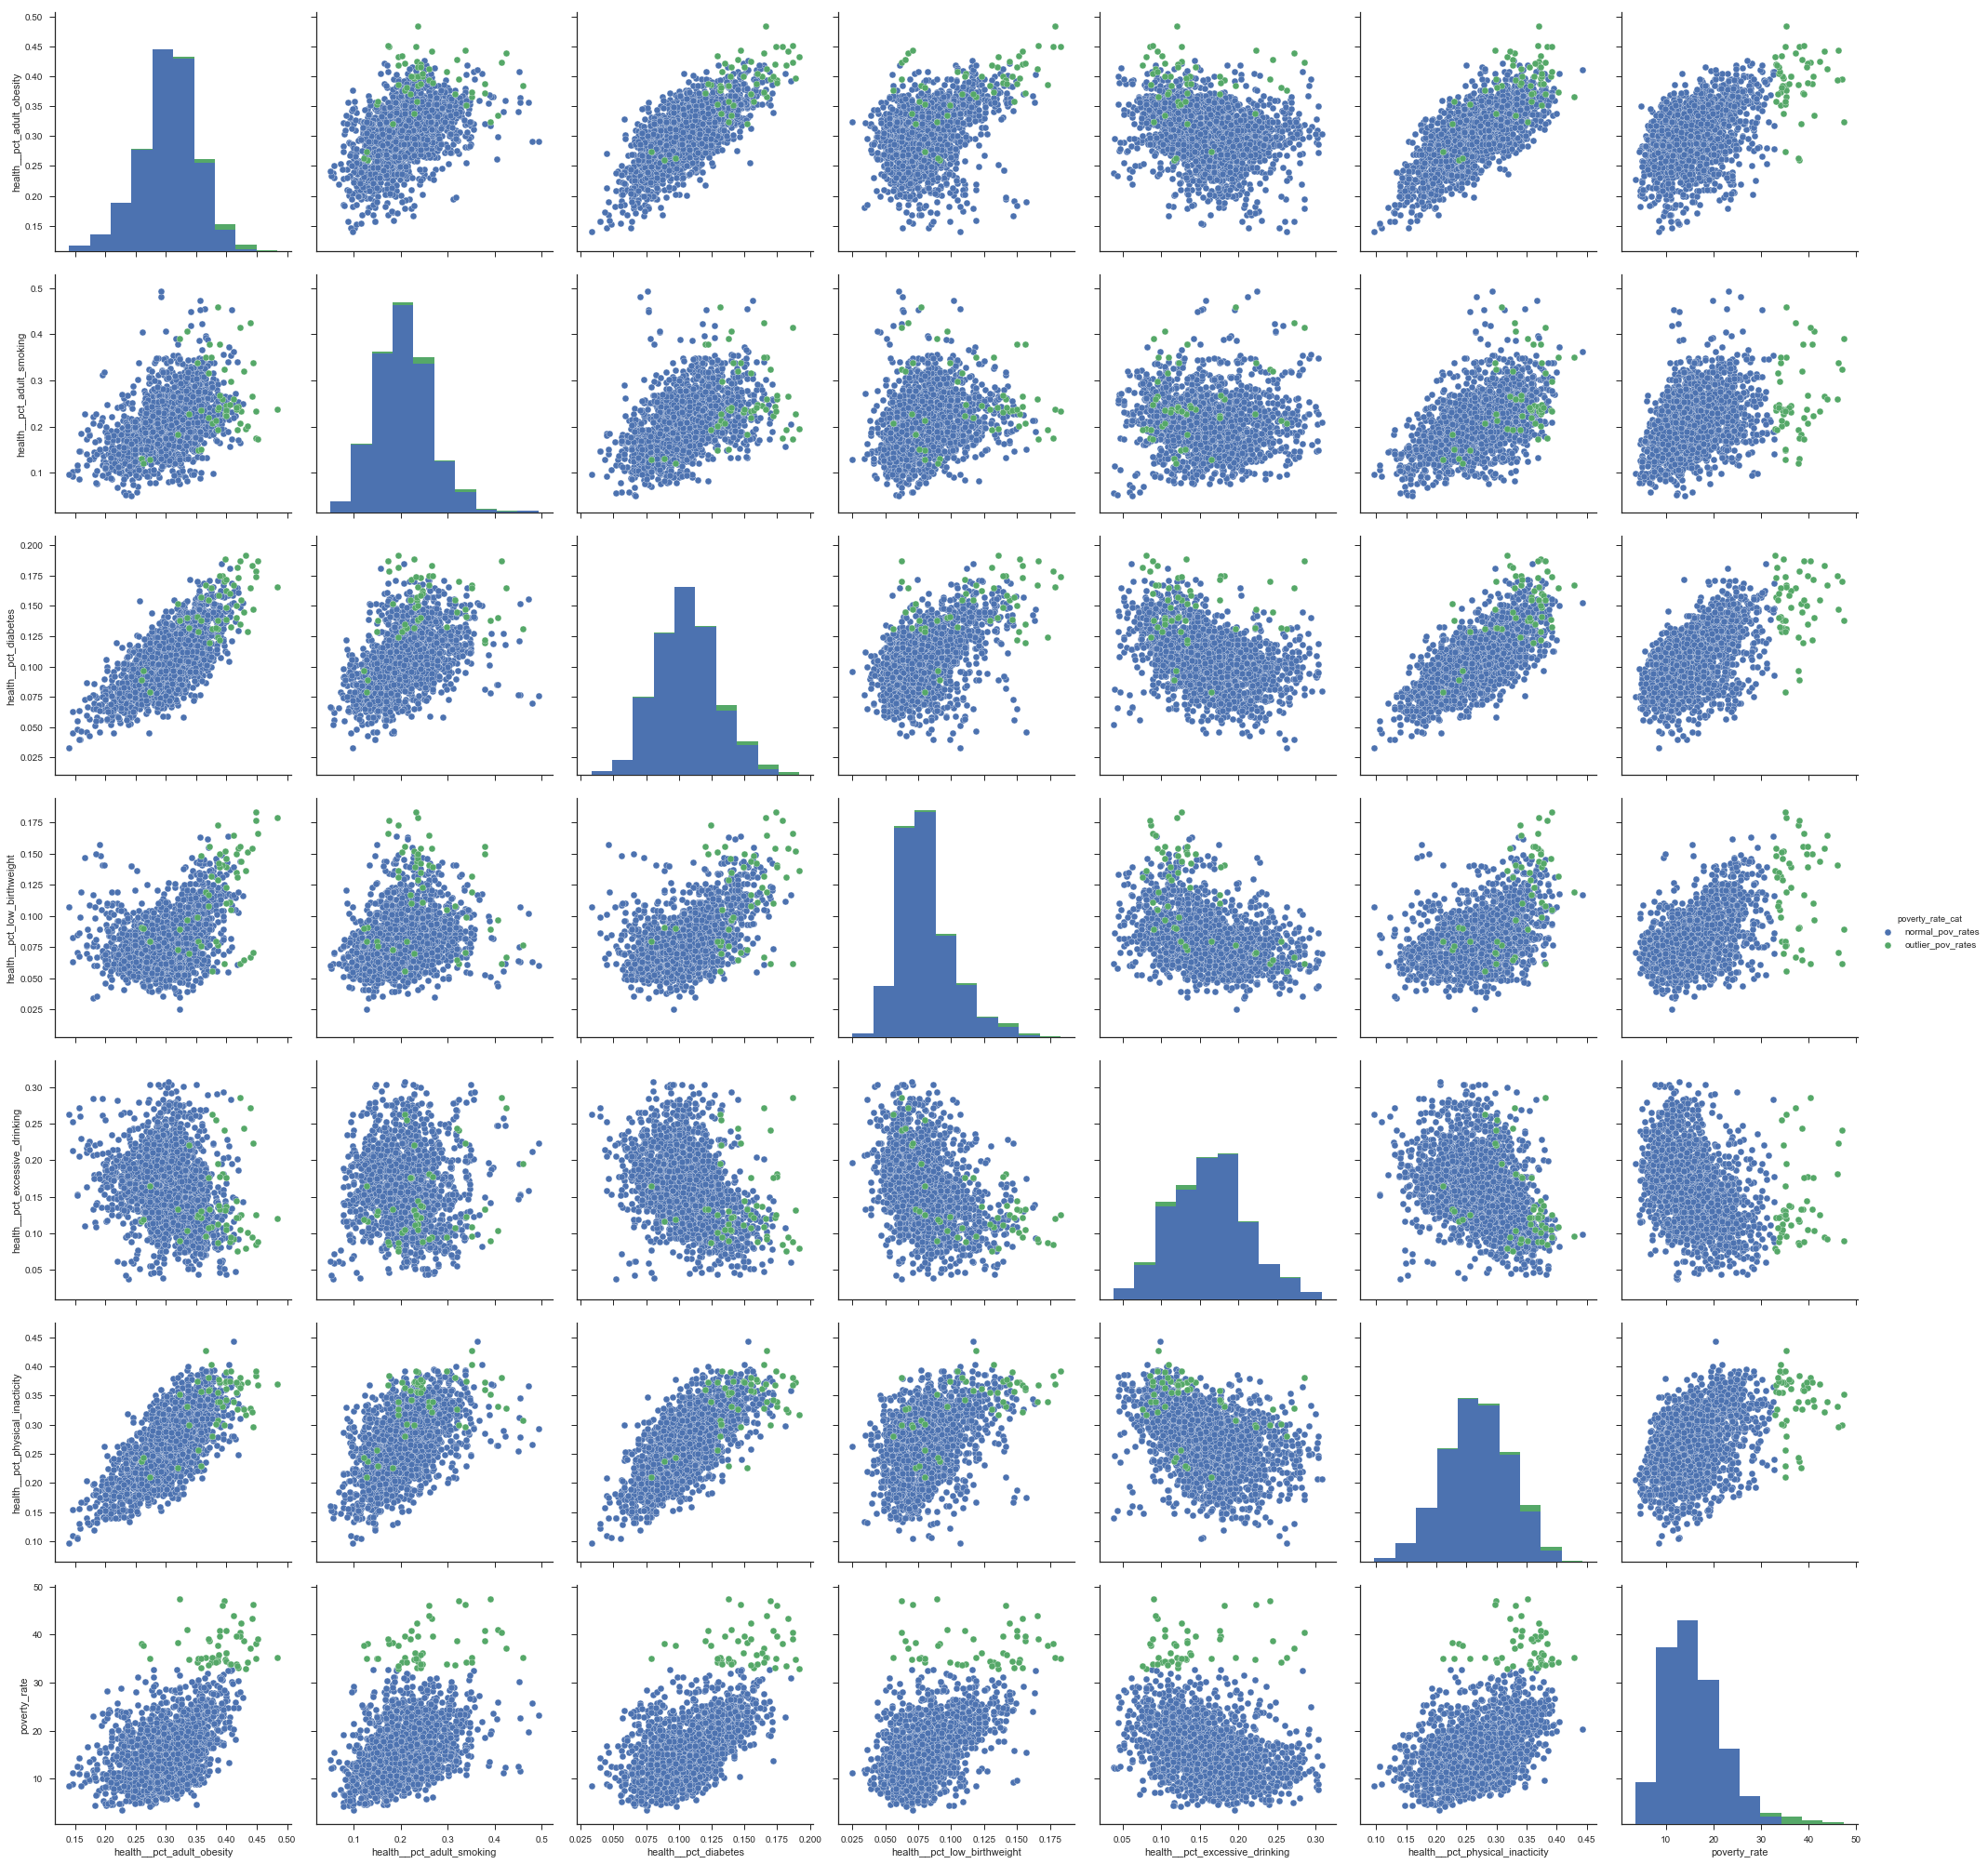

In [88]:
scatter_health1 = sns.pairplot(poverty.loc[:, ['health__pct_adult_obesity','health__pct_adult_smoking'
                                              ,'health__pct_diabetes','health__pct_low_birthweight'
                                              ,'health__pct_excessive_drinking','health__pct_physical_inacticity'
                                              ,'poverty_rate','poverty_rate_cat']].dropna(), size=4, hue='poverty_rate_cat')

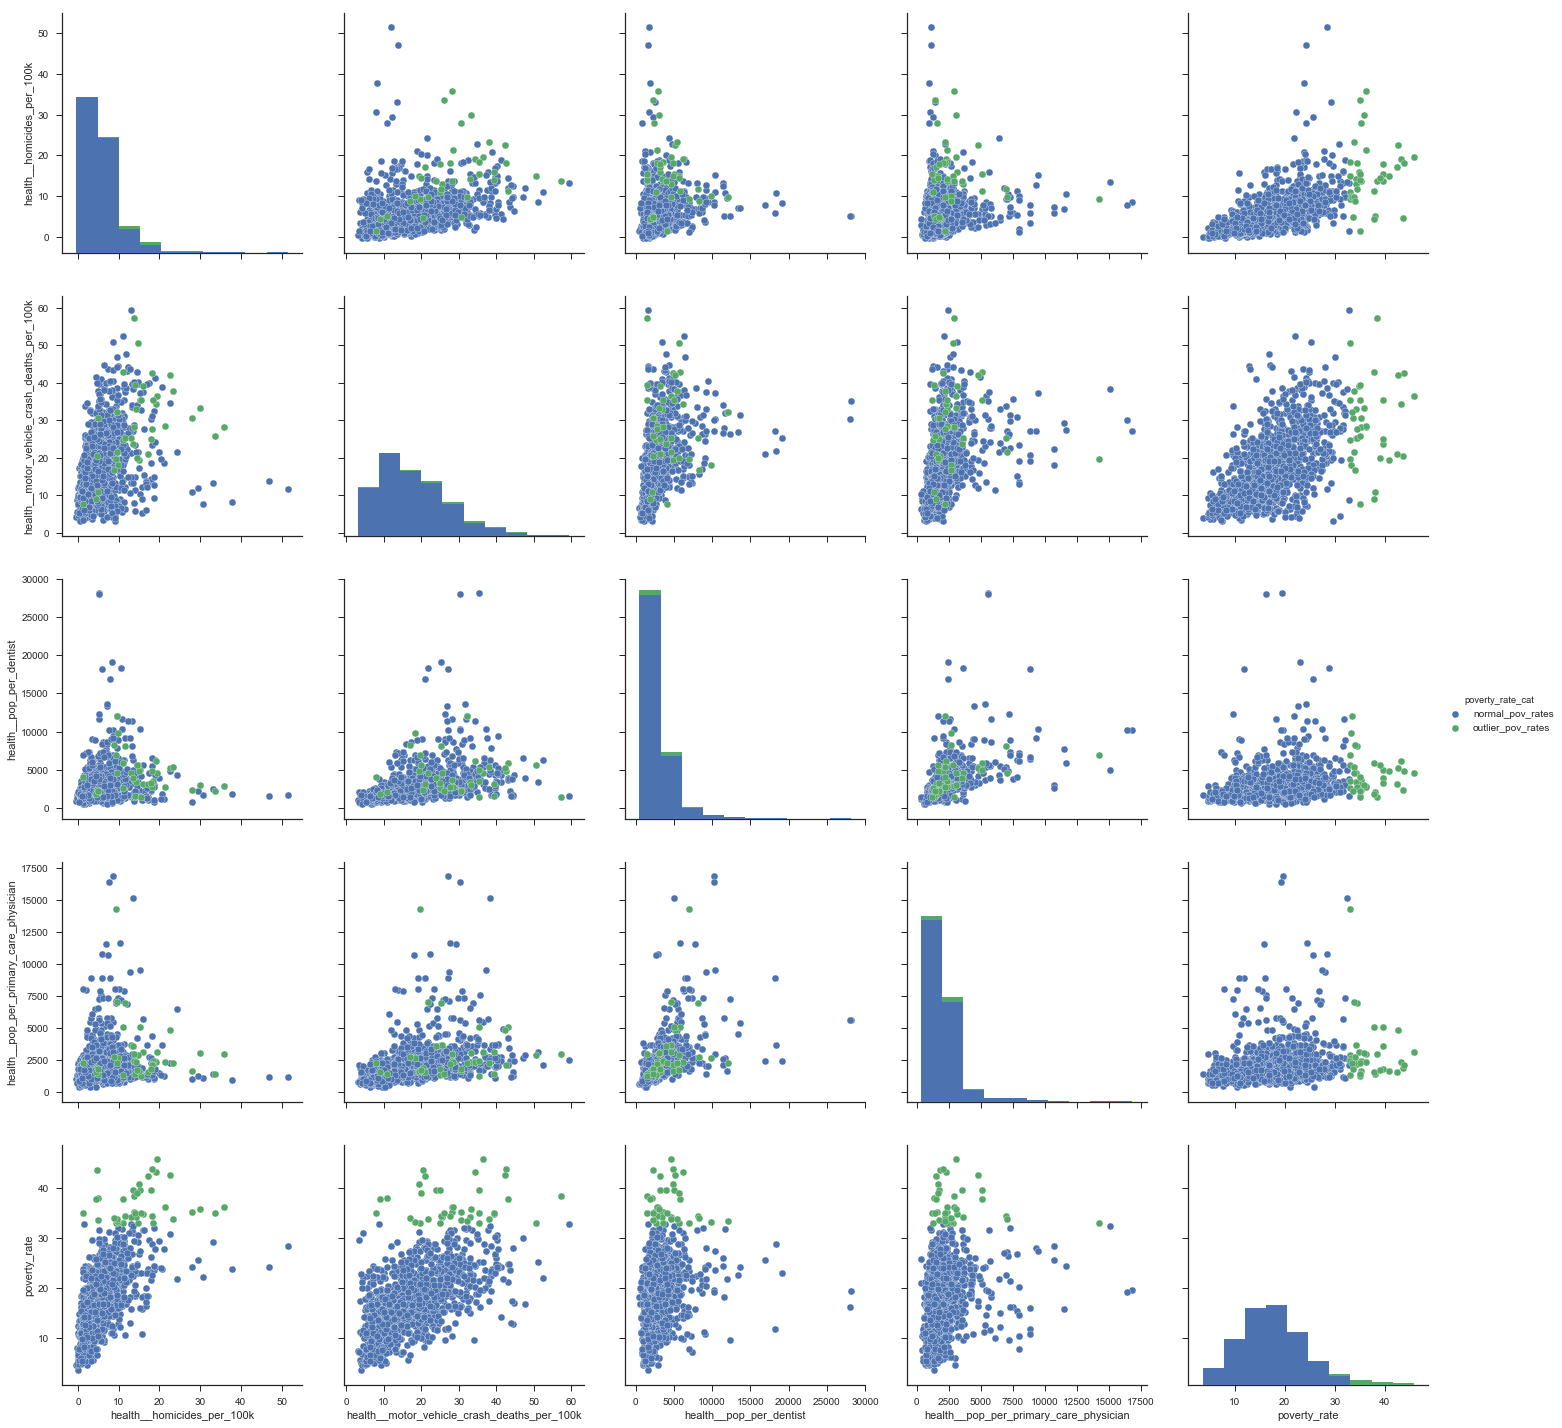

In [89]:
scatter_health2 = sns.pairplot(poverty.loc[:, ['health__homicides_per_100k'
                                              ,'health__motor_vehicle_crash_deaths_per_100k'
                                              ,'health__pop_per_dentist','health__pop_per_primary_care_physician'
                                              ,'poverty_rate','poverty_rate_cat']].dropna(), size=4, hue='poverty_rate_cat')

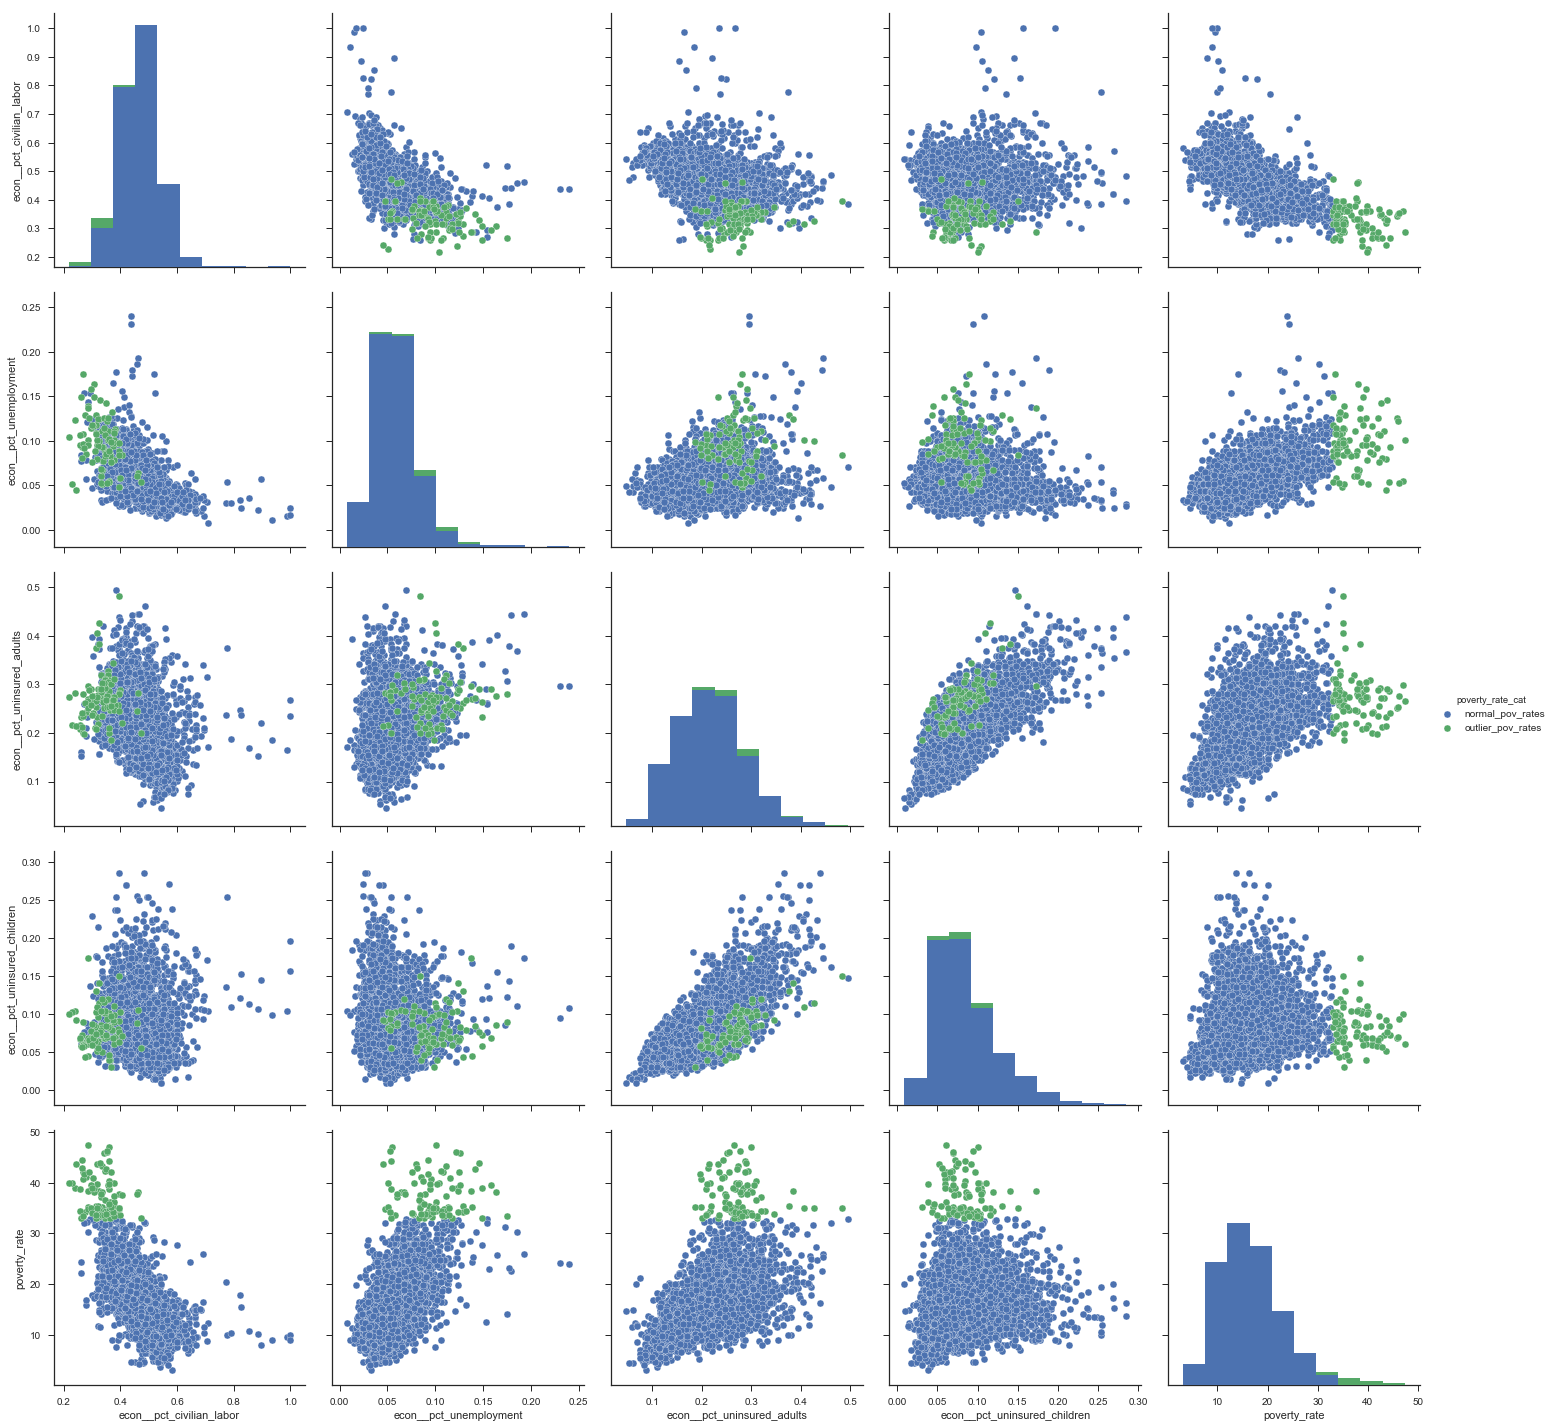

In [90]:
scatter_econ = sns.pairplot(poverty.loc[:, ['econ__pct_civilian_labor'
                                              ,'econ__pct_unemployment'
                                              ,'econ__pct_uninsured_adults','econ__pct_uninsured_children'
                                              ,'poverty_rate','poverty_rate_cat']].dropna(), size=4, hue='poverty_rate_cat')

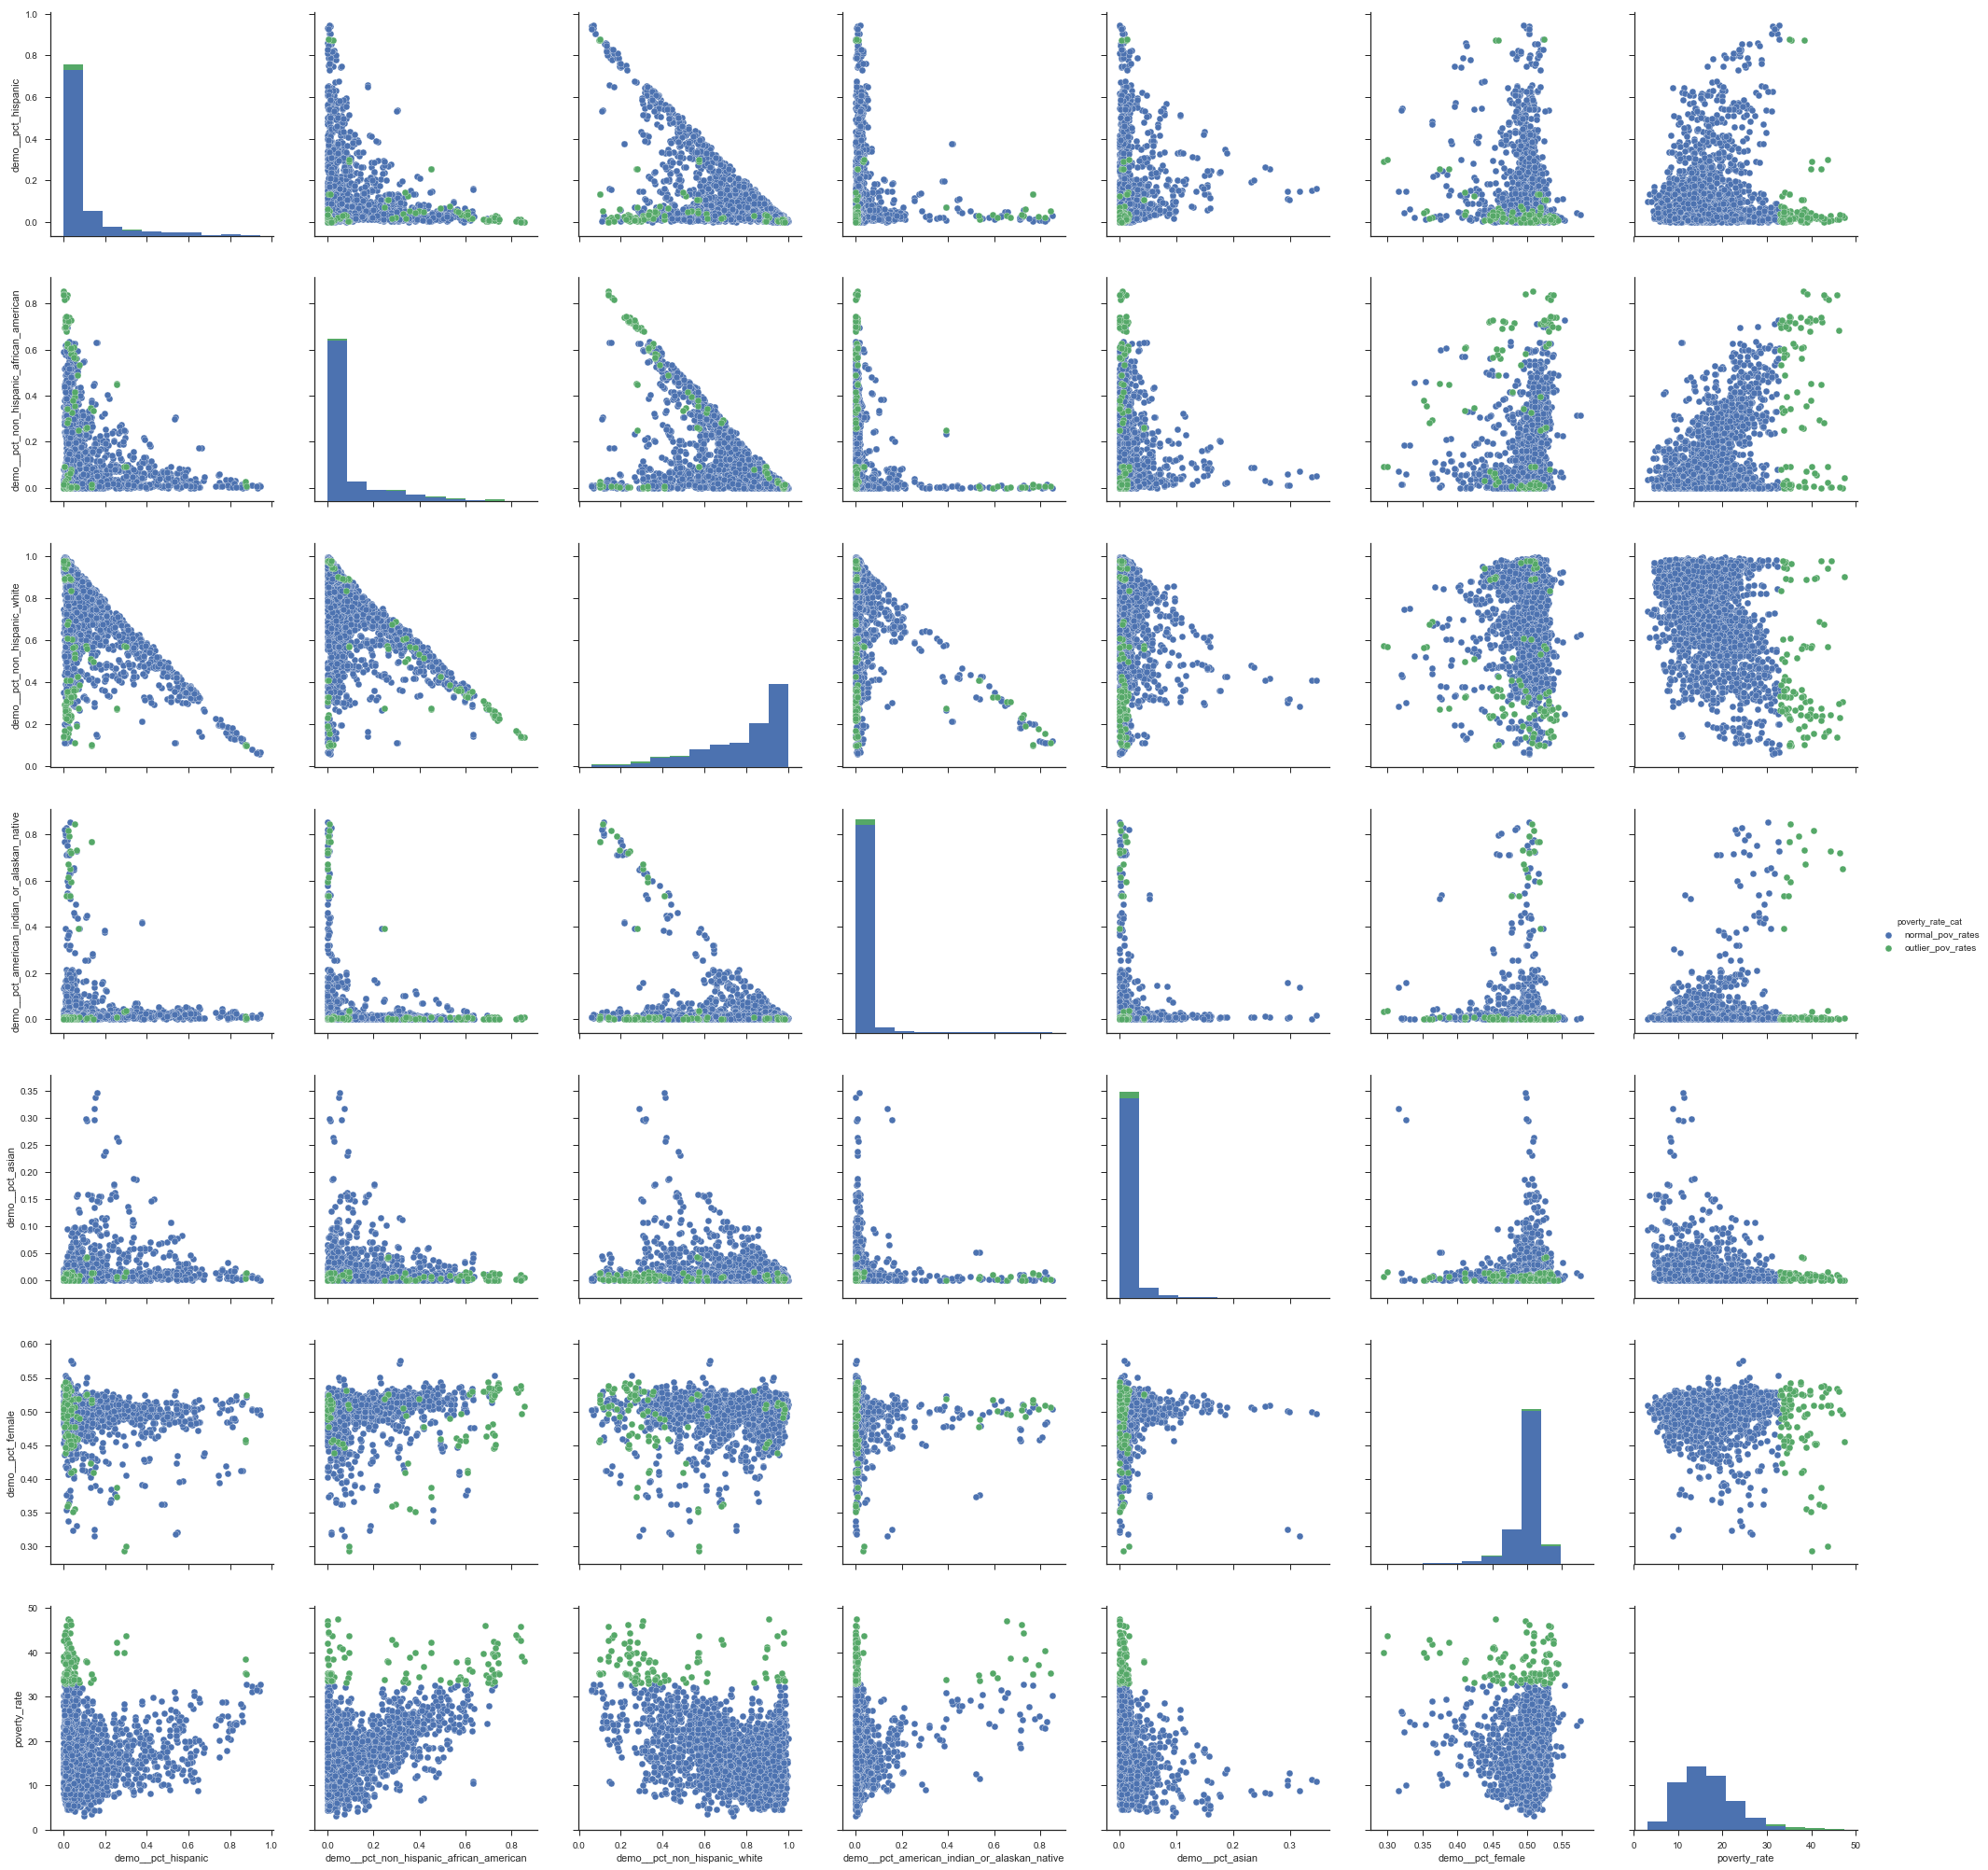

In [91]:
scatter_ethnic = sns.pairplot(poverty.loc[:, ['demo__pct_hispanic'
                                              ,'demo__pct_non_hispanic_african_american'
                                              ,'demo__pct_non_hispanic_white','demo__pct_american_indian_or_alaskan_native'
                                              ,'demo__pct_asian', 'demo__pct_female'
                                              ,'poverty_rate','poverty_rate_cat']].dropna(), size=4, hue='poverty_rate_cat')

These quantitative features behave like categorical features. 

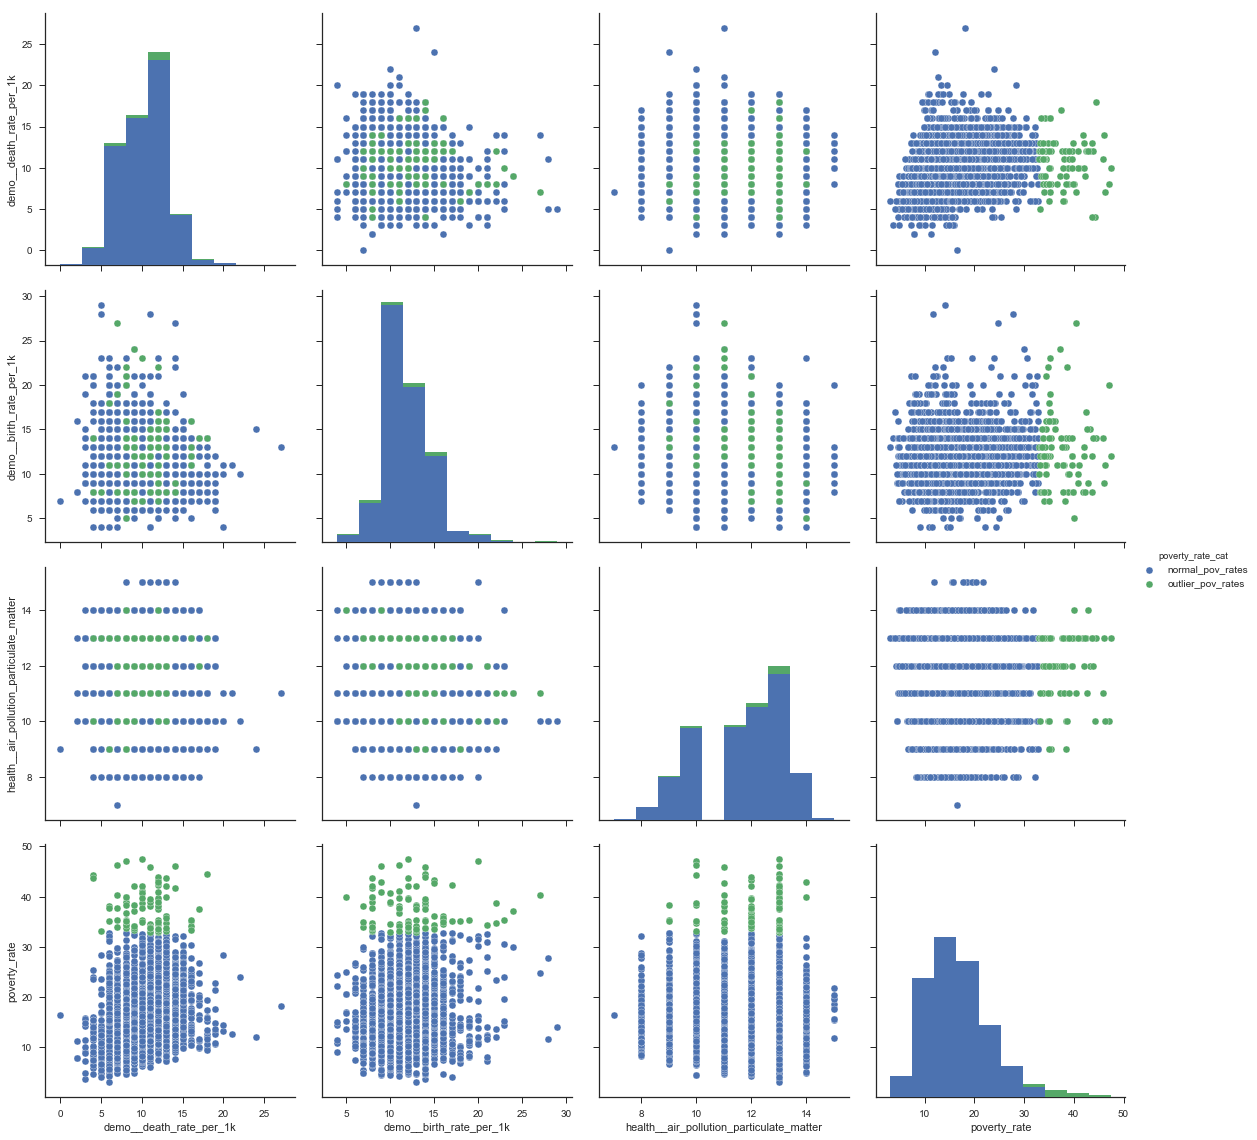

In [92]:
scatter_non_ln = sns.pairplot(poverty.loc[:, ['demo__death_rate_per_1k'
                                              ,'demo__birth_rate_per_1k'
                                              ,'health__air_pollution_particulate_matter'
                                              ,'poverty_rate','poverty_rate_cat']].dropna(), size=4, hue='poverty_rate_cat')

#### Creation and Visualization of New Categorical Variables
From observing the scatterplot matrices of the features 'demo\_\_death\_rate\_per\_1k', 'demo\_\_birth\_rate\_per\_1k' and 'health\_\_air\_pollution\_particulate\_matter' is clear that these quantitative variables behave like categorical variables. They will be transformed into categorical features by binning them.

In [93]:
def create_birthrate_cat(input_df):
    cats = [ "birthrate {0} - {1}".format(i, i + 5) for i in range(0, 40, 5) ]
    input_df.loc[:,'birth_rate_cat'] = pd.cut(input_df.demo__birth_rate_per_1k, range(0, 45, 5), right=False, include_lowest=True, labels=cats)
    input_df.loc[:,'birth_rate_cat'] = input_df.birth_rate_cat.astype('category')
    input_df.loc[:,'birth_rate_cat'] = input_df.birth_rate_cat.cat.set_categories(cats, ordered=True)
    return input_df

In [94]:
def create_deathrate_cat(input_df):
    cats = [ "deathrate {0} - {1}".format(i, i + 5) for i in range(0, 40, 5) ]
    input_df.loc[:,'death_rate_cat'] = pd.cut(input_df.demo__death_rate_per_1k, range(0, 45, 5), right=False, include_lowest=True, labels=cats)
    input_df.loc[:,'death_rate_cat'] = input_df.death_rate_cat.astype('category')
    input_df.loc[:,'death_rate_cat'] = input_df.death_rate_cat.cat.set_categories(cats, ordered=True)
    return input_df

In [95]:
def create_air_poll_cat(input_df):
    cats = [ "airpoll {0} - {1}".format(i, i + 5) for i in range(0, 35, 5) ]
    input_df.loc[:,'air_poll_cat'] = pd.cut(input_df.health__air_pollution_particulate_matter, range(0, 40, 5), right=False, include_lowest=True, labels=cats)
    input_df.loc[:,'air_poll_cat'] = input_df.air_poll_cat.astype('category')
    input_df.loc[:,'air_poll_cat'] = input_df.air_poll_cat.cat.set_categories(cats, ordered=True)
    return input_df

In [96]:
def create_features(input_df):
    input_df = create_birthrate_cat(input_df)
    input_df = create_deathrate_cat(input_df)
    input_df = create_air_poll_cat(input_df)
    return input_df

In [97]:
poverty = create_features(poverty)

## Data Preparation
This phase involves mostly the cleaning, scaling and one hot encoding of features:
* dropping redundant features
* converting features to the right type
* missing values are replaced by the respective median value of the feature. The median is prefered over the mean because it is less sensible to skewed data and gives a better measure of centrality.
* features are scaled to have the same scale. The MinMaxScaler is applied to the features 'health\_\_homicides\_per\_100k' and 'health\_\_motor\_vehicle\_crash\_deaths\_per\_100k' to scale them the same way as other quantitative variables that are in percentages between 0 and 1.
* One hot encoding of the categorical variables is performed

### Drop columns

In [127]:
def drop_features(input_df):
    result_df = input_df.drop(columns=['health__air_pollution_particulate_matter'
                                      ,'demo__death_rate_per_1k', 'demo__birth_rate_per_1k'
                                      ,'pct_65years_cat','area__urban_influence','yr'], axis=1)
    return result_df

In [128]:
poverty_clean = drop_features(poverty)

### Convert feature to right type

In [129]:
def convert_to_cat(input_df):
    input_df.loc[:,'area__rucc'] = input_df.area__rucc.astype("category")
    input_df.loc[:,'econ__economic_typology'] = input_df.econ__economic_typology.astype("category")
    return input_df

In [130]:
poverty_clean = convert_to_cat(poverty_clean)

In [131]:
poverty_clean.dtypes

row_id                                                 int64
area__rucc                                          category
econ__economic_typology                             category
econ__pct_civilian_labor                             float64
econ__pct_unemployment                               float64
econ__pct_uninsured_adults                           float64
econ__pct_uninsured_children                         float64
demo__pct_female                                     float64
demo__pct_below_18_years_of_age                      float64
demo__pct_aged_65_years_and_older                    float64
demo__pct_hispanic                                   float64
demo__pct_non_hispanic_african_american              float64
demo__pct_non_hispanic_white                         float64
demo__pct_american_indian_or_alaskan_native          float64
demo__pct_asian                                      float64
demo__pct_adults_less_than_a_high_school_diploma     float64
demo__pct_adults_with_hi

### Replace Missing Values

In [132]:
def clean_nans(input_df):
    result_df = input_df.fillna(poverty_clean.median())
    return result_df

In [133]:
poverty_clean = clean_nans(poverty_clean)
poverty_clean.shape

(3198, 35)

As we can see here under there are no missing values.

In [134]:
poverty_clean.isnull().sum()

row_id                                               0
area__rucc                                           0
econ__economic_typology                              0
econ__pct_civilian_labor                             0
econ__pct_unemployment                               0
econ__pct_uninsured_adults                           0
econ__pct_uninsured_children                         0
demo__pct_female                                     0
demo__pct_below_18_years_of_age                      0
demo__pct_aged_65_years_and_older                    0
demo__pct_hispanic                                   0
demo__pct_non_hispanic_african_american              0
demo__pct_non_hispanic_white                         0
demo__pct_american_indian_or_alaskan_native          0
demo__pct_asian                                      0
demo__pct_adults_less_than_a_high_school_diploma     0
demo__pct_adults_with_high_school_diploma            0
demo__pct_adults_with_some_college                   0
demo__pct_

### TODO Scale Features!!!

In [135]:
def scale_features(input_df):
    input_scale = input_df.loc[:,['health__homicides_per_100k'
                                    ,'health__motor_vehicle_crash_deaths_per_100k'
                                 ,'health__pop_per_dentist'
                                 ,'health__pop_per_primary_care_physician']]
    
    input_scaled = pd.DataFrame(MinMaxScaler().fit_transform(input_scale), columns=input_scale.columns)
    
    input_df.loc[:,'health__homicides_per_100k'] = input_scaled.loc[:,'health__homicides_per_100k']
    input_df.loc[:,'health__motor_vehicle_crash_deaths_per_100k'] = input_scaled.loc[:,'health__motor_vehicle_crash_deaths_per_100k']
    input_df.loc[:,'health__pop_per_dentist'] = input_scaled.loc[:,'health__pop_per_dentist']
    input_df.loc[:,'health__pop_per_primary_care_physician'] = input_scaled.loc[:,'health__pop_per_primary_care_physician']
    return input_df

In [136]:
poverty_clean = scale_features(poverty_clean)
poverty_clean.describe()

row_id  econ__pct_civilian_labor  econ__pct_unemployment  \
count  3198.000000               3198.000000              3198.00000   
mean   3156.692620                  0.467071                 0.05961   
std    1823.959278                  0.074541                 0.02285   
min       0.000000                  0.217000                 0.00800   
25%    1561.750000                  0.420000                 0.04400   
50%    3198.500000                  0.467000                 0.05700   
75%    4723.750000                  0.514000                 0.07100   
max    6277.000000                  1.000000                 0.24000   

       econ__pct_uninsured_adults  econ__pct_uninsured_children  \
count                 3198.000000                   3198.000000   
mean                     0.217533                      0.085915   
std                      0.067351                      0.039993   
min                      0.046000                      0.009000   
25%                      0.166250                      0.057000   
50%                      0.216000                      0.077000   
75%                      0.262000                      0.105000   
max                      0.495000                      0.285000   

       demo__pct_female  demo__pct_below_18_years_of_age  \
count       3198.000000                      3198.000000   
mean           0.498783                         0.227762   
std            0.024243                         0.034280   
min            0.294000                         0.098000   
25%            0.493000                         0.207000   
50%            0.503000                         0.226000   
75%            0.512000                         0.245000   
max            0.576000                         0.417000   

       demo__pct_aged_65_years_and_older  demo__pct_hispanic  \
count                        3198.000000         3198.000000   
mean                            0.170135            0.090199   
std                             0.043580            0.142669   
min                             0.043000            0.000000   
25%                             0.142000            0.019000   
50%                             0.167000            0.035000   
75%                             0.194000            0.088000   
max                             0.355000            0.945000   

       demo__pct_non_hispanic_african_american  demo__pct_non_hispanic_white  \
count                              3198.000000                   3198.000000   
mean                                  0.091073                      0.770260   
std                                   0.147068                      0.207849   
min                                   0.000000                      0.060000   
25%                                   0.006000                      0.648250   
50%                                   0.022000                      0.854000   
75%                                   0.096000                      0.936000   
max                                   0.855000                      0.998000   

       demo__pct_american_indian_or_alaskan_native  demo__pct_asian  \
count                                  3198.000000      3198.000000   
mean                                      0.024648         0.013300   
std                                       0.084609         0.025358   
min                                       0.000000         0.000000   
25%                                       0.002000         0.003000   
50%                                       0.007000         0.007000   
75%                                       0.014000         0.013000   
max                                       0.852000         0.346000   

       demo__pct_adults_less_than_a_high_school_diploma  \
count                                       3198.000000   
mean                                           0.148794   
std                                            0.068255   
min                                         

### One Hot Encoding of Categorical Variables

In [137]:
def cat_to_dummies(input_df):
    result_df = pd.get_dummies(input_df, dummy_na=True, columns=['area__rucc','econ__economic_typology'
                                                                ,'birth_rate_cat','death_rate_cat','air_poll_cat'
                                                                ,'aui_pct65y_cat'])
    return result_df

In [138]:
poverty_clean = cat_to_dummies(poverty_clean)

In [139]:
poverty_clean.shape

(3198, 97)

### Classifying

In [147]:
adaClf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5, splitter='random', criterion='entropy'
                                                 , random_state=rng)
                           , n_estimators=500, learning_rate=1, random_state=rng)

In [148]:
clf_cachedir = mkdtemp()
clf_estimators = [('clf', adaClf)]
clf_pipe = Pipeline(clf_estimators, memory=clf_cachedir)
clf_param_grid = dict(clf=[adaClf])

In [149]:
clf_grid = GridSearchCV(estimator=clf_pipe, param_grid=clf_param_grid, scoring='accuracy', cv=5
                        , error_score=0, refit='accuracy')
clf_pred = clf_grid.fit(poverty_clean.drop(columns=['row_id','poverty_rate','poverty_rate_cat'], axis=1), poverty_clean.loc[:,'poverty_rate_cat'])
clf_pred.best_estimator_

Pipeline(memory='/var/folders/_j/vyb4dyfx2wq850vj9vh25wy40000gn/T/tmpclia2xtt',
     steps=[('clf', AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf...ning_rate=1, n_estimators=500,
          random_state=<mtrand.RandomState object at 0x1a24d59f78>))])

In [150]:
train_scores = cross_validate(clf_grid, poverty_clean.drop(columns=['row_id','poverty_rate','poverty_rate_cat'], axis=1), poverty_clean.loc[:,'poverty_rate_cat'], cv=5, scoring='accuracy', return_train_score=True)
train_scores

{'fit_time': array([ 18.90039086,  19.36935091,  19.42356515,  18.95462418,  18.94691396]),
 'score_time': array([ 0.08492804,  0.09058595,  0.08287787,  0.08373404,  0.08904409]),
 'test_score': array([ 0.98283931,  0.98125   ,  0.98904538,  0.9827856 ,  0.99061033]),
 'train_score': array([ 1.,  1.,  1.,  1.,  1.])}

## Modelling and Evaluation
In this phase two models are compared with each other using the RMSE evaluation metric:
* Least Square Linear Model after applying recursive feature selection to create a linear model with the most important features
* An AdaBoostRegressor which is an ensemble learning model of decision trees.

The best RMSE scores obtained by these two models are:

| Model           | RMSE 
|:----------------|:------
|AdaBoostRegressor|  2.7853
|Linear Regression|  2.9297

The AdaBoostRegressor happens to be more precise than the Least Squares Linear Model because it can handle non linear relationships. The AdaBoostRegressor is chosen as the regression model to predict poverty rates for United States Counties.

In [154]:
rng = np.random.RandomState(0)

In [155]:
normal_mask = poverty_clean.poverty_rate_cat == 'normal_pov_rates'
outlier_mask = poverty_clean.poverty_rate_cat == 'outlier_pov_rates'

poverty_normal_X = poverty_clean.loc[normal_mask,:].drop(columns=['row_id','poverty_rate','poverty_rate_cat'], axis=1)
poverty_normal_y = poverty_clean.loc[normal_mask,:].poverty_rate

poverty_outlier_X = poverty_clean.loc[outlier_mask,:].drop(columns=['row_id','poverty_rate','poverty_rate_cat'], axis=1)
poverty_outlier_y = poverty_clean.loc[outlier_mask,:].poverty_rate

In [175]:
poverty_normal_y.describe()

count    3106.000000
mean       16.200000
std         5.701105
min         2.500000
25%        11.900000
50%        15.550000
75%        19.700000
max        32.800000
Name: poverty_rate, dtype: float64

In [176]:
poverty_outlier_y.describe()

count    92.000000
mean     37.652174
std       3.902281
min      33.000000
25%      34.375000
50%      36.450000
75%      39.925000
max      47.400000
Name: poverty_rate, dtype: float64

In [156]:
# use r2 adjusted in the future
scoring = {'r2':'r2','mse': make_scorer(mean_squared_error, greater_is_better=False)}

In [157]:
inner_cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=rng)
outer_cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=rng)

### Linear Regression Feature Selection

In [163]:
caching = mkdtemp()

mse = make_scorer(mean_squared_error, greater_is_better=False)
rfecv = RFECV(estimator=LinearRegression(), step=1, cv=inner_cv, scoring=mse)
rfecv.fit(poverty_normal_X, poverty_normal_y)

print("Optimal number of features : %d" % rfecv.n_features_)

train_scores = cross_validate(rfecv, poverty_normal_X, poverty_normal_y, cv=outer_cv, scoring=scoring, return_train_score=True)
pprint(np.average(np.abs(train_scores['test_r2'])))
pprint(np.average(np.sqrt(np.abs(train_scores['test_mse']))))

Optimal number of features : 37
2.4516272071187329e+21
168381135744.39383


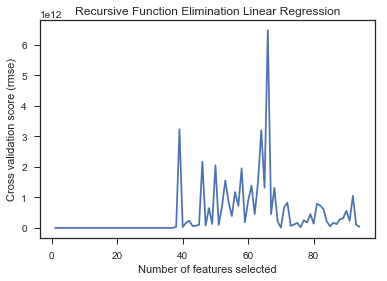

In [164]:
plt.figure()
plt.title('Recursive Function Elimination Linear Regression')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (rmse)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), np.sqrt(np.abs(rfecv.grid_scores_)))
plt.show()

In [165]:
caching = mkdtemp()

mse = make_scorer(mean_squared_error, greater_is_better=False)
rfecv = RFECV(estimator=LinearRegression(), step=1, cv=inner_cv, scoring=mse)
rfecv.fit(poverty_outlier_X, poverty_outlier_y)

print("Optimal number of features : %d" % rfecv.n_features_)

train_scores = cross_validate(rfecv, poverty_outlier_X, poverty_outlier_y, cv=outer_cv, scoring=scoring, return_train_score=True)
pprint(np.average(np.abs(train_scores['test_r2'])))
pprint(np.average(np.sqrt(np.abs(train_scores['test_mse']))))

Optimal number of features : 3
0.18684996823870373
3.9511546423721575


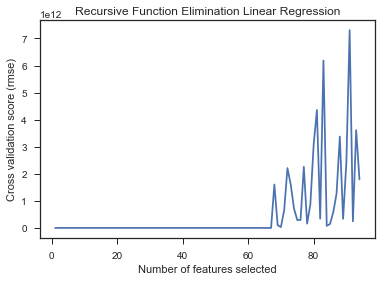

In [166]:
plt.figure()
plt.title('Recursive Function Elimination Linear Regression')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (rmse)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), np.sqrt(np.abs(rfecv.grid_scores_)))
plt.show()

### AdaBoostRegressor
After hyper parameter tuning using nested cross validation of the AdaBoostRegressor the following parameters give the lowest RMSE score:

In [177]:
param_grid = {'loss': ['linear']}

adaReg = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=13, splitter='random', criterion='mse'
                                                , random_state=rng)
                           , n_estimators=600, loss='linear', learning_rate=1, random_state=rng)

In [178]:
reg_grid_normal = GridSearchCV(estimator=adaReg, param_grid=param_grid, scoring=scoring, cv=inner_cv
                        , error_score=0, refit='mse')
reg_pred = reg_grid_normal.fit(poverty_normal_X, poverty_normal_y)

pprint(reg_pred.best_estimator_)

train_scores = cross_validate(reg_grid_normal, poverty_normal_X, poverty_normal_y, cv=outer_cv, scoring=scoring, return_train_score=True)
pprint(np.average(np.abs(train_scores['test_r2'])))
pprint(np.average(np.sqrt(np.abs(train_scores['test_mse']))))

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=13, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False,
           random_state=<mtrand.RandomState object at 0x1a286f2ab0>,
           splitter='random'),
         learning_rate=1, loss='linear', n_estimators=600,
         random_state=<mtrand.RandomState object at 0x1a2a109048>)
0.84500565360702284
2.233790373456408


In [179]:
reg_grid_outlier = GridSearchCV(estimator=adaReg, param_grid=param_grid, scoring=scoring, cv=inner_cv
                        , error_score=0, refit='mse')
reg_pred = reg_grid_outlier.fit(poverty_outlier_X, poverty_outlier_y)

pprint(reg_pred.best_estimator_)

train_scores = cross_validate(reg_grid_outlier, poverty_outlier_X, poverty_outlier_y, cv=outer_cv, scoring=scoring, return_train_score=True)
pprint(np.average(np.abs(train_scores['test_r2'])))
pprint(np.average(np.sqrt(np.abs(train_scores['test_mse']))))

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=13, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False,
           random_state=<mtrand.RandomState object at 0x1a2a0373f0>,
           splitter='random'),
         learning_rate=1, loss='linear', n_estimators=600,
         random_state=<mtrand.RandomState object at 0x1a2895a2d0>)
0.1970640438549271
3.690647234740525


### Feature Selection
To improve the AdaBoostRegressor even more, the best features are selected using recursive feature elimination or backwards elimination.

In [ ]:
mse = make_scorer(mean_squared_error, greater_is_better=False)
rfecv = RFECV(estimator=adaReg, step=1, cv=inner_cv, scoring=mse)
rfecv.fit(poverty_X, poverty_y)

print("Optimal number of features : %d" % rfecv.n_features_)

train_scores = cross_validate(rfecv, poverty_normal_X, poverty_normal_y, cv=outer_cv, scoring=scoring, return_train_score=True)
pprint(np.average(np.abs(train_scores['test_r2'])))
pprint(np.average(np.sqrt(np.abs(train_scores['test_mse']))))

In [ ]:
plt.figure()
plt.title('Recursive Function Elimination AdaBoostRegressor')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (rmse)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), np.sqrt(np.abs(rfecv.grid_scores_)))
plt.show()

In [ ]:
mse = make_scorer(mean_squared_error, greater_is_better=False)
rfecv = RFECV(estimator=adaReg, step=1, cv=inner_cv, scoring=mse)
rfecv.fit(poverty_X, poverty_y)

print("Optimal number of features : %d" % rfecv.n_features_)

train_scores = cross_validate(rfecv, poverty_outlier_X, poverty_outlier_y, cv=outer_cv, scoring=scoring, return_train_score=True)
pprint(np.average(np.abs(train_scores['test_r2'])))
pprint(np.average(np.sqrt(np.abs(train_scores['test_mse']))))

In [ ]:
plt.figure()
plt.title('Recursive Function Elimination AdaBoostRegressor')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (rmse)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), np.sqrt(np.abs(rfecv.grid_scores_)))
plt.show()

### Analysis of Predictions and Residuals
The Analysis of the quality of the predictions and residuals shows that the accuracy of the AdaBoostRegressor is  high. However the AdaBoostRegressor probably slightly overfits the data.

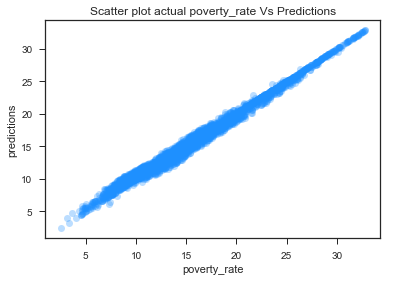

In [181]:
sc1_tmp = sns.regplot(x=poverty_normal_y, y=reg_grid_normal.predict(poverty_normal_X), fit_reg=False, color='dodgerblue', scatter_kws={'alpha':0.3})
tmp = sc1_tmp.set_ylabel('predictions')
tmp = sc1_tmp.set_title('Scatter plot actual poverty_rate Vs Predictions')

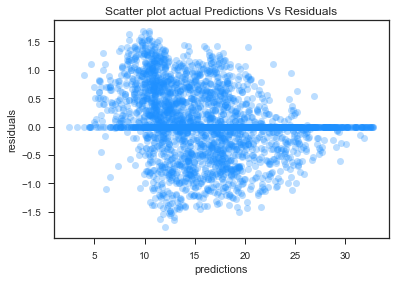

In [182]:
sc2_tmp = sns.regplot(x=reg_grid_normal.predict(poverty_normal_X), y=reg_grid_normal.predict(poverty_normal_X) - poverty_normal_y
                      , fit_reg=False, color='dodgerblue', scatter_kws={'alpha':0.3})
tmp = sc2_tmp.set_xlabel('predictions')
tmp = sc2_tmp.set_ylabel('residuals')
tmp = sc2_tmp.set_title('Scatter plot actual Predictions Vs Residuals')

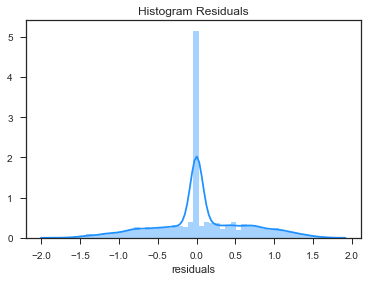

In [183]:
residuals = reg_grid_normal.predict(poverty_normal_X) - poverty_normal_y
residuals = residuals.rename('residuals')
ht_pov = sns.distplot(residuals, color='dodgerblue').set_title('Histogram Residuals')

## Test

In [399]:
poverty_test = pd.read_csv('./Microsoft_-_DAT102x_Predicting_Poverty_in_the_United_States_-_Test_values.csv')

In [400]:
poverty_test.shape

(3080, 34)

In [401]:
#Create Features
poverty_test = create_old_age_cat(poverty_test)
poverty_test = create_aui_pct65y_cat(poverty_test)
poverty_test = create_features(poverty_test)

#Convert to correct type
poverty_test = convert_to_cat(poverty_test)

#Drop Features
poverty_row_id = poverty_test.row_id
poverty_test = drop_features(poverty_test)
poverty_test = poverty_test.drop(columns=['row_id'], axis=1)

#Replace NANs
poverty_test_clean = poverty_test.fillna(poverty_test.median())
poverty_test_clean = cat_to_dummies(poverty_test_clean)

#Scale Features
poverty_test_clean = scale_features(poverty_test_clean)

In [402]:
poverty_test_clean.shape

(3080, 94)

In [403]:
#Classify
pov_class = pd.DataFrame(clf_grid.predict(poverty_test_clean))
pov_class = pd.concat([poverty_row_id, pov_class], axis=1)
pov_class = pov_class.rename(index=str, columns={0: 'poverty_rate_cat'})
pov_class = pov_class.set_index(poverty_row_id.index)

pv_normal_mask = pov_class.loc[:,'poverty_rate_cat'] == 'normal_pov_rates'
pv_outlier_mask = pov_class.loc[:,'poverty_rate_cat'] == 'outlier_pov_rates'

pprint(pov_class.shape)

(3080, 2)


In [405]:
#Create Prediction
input_normal = poverty_test_clean.loc[pv_normal_mask,:]
row_id_normal = pd.DataFrame(pov_class.loc[pv_normal_mask,'row_id'])
submission_normal = pd.DataFrame(reg_grid_normal.predict(input_normal))
submission_normal = np.clip(submission_normal,2.50, 33.00)
submission_normal = submission_normal.set_index(row_id_normal.index)
# subm_normal = pd.concat([row_id_normal, submission_normal], axis=1)
submission_normal = pd.merge(row_id_normal, submission_normal, right_index=True, left_index=True)

input_outlier = poverty_test_clean.loc[pv_outlier_mask,:]
row_id_outlier = pd.DataFrame(pov_class.loc[pv_outlier_mask,'row_id'])
submission_outlier = pd.DataFrame(reg_grid_outlier.predict(input_outlier))
submission_outlier = np.clip(submission_outlier,33.00, 48.00)
submission_outlier = submission_outlier.set_index(row_id_outlier.index)
# subm_outlier = pd.concat([row_id_outlier, submission_outlier], axis=1)
submission_outlier = pd.merge(row_id_outlier, submission_outlier, right_index=True, left_index=True)

In [406]:
submission_outlier.head(34)

row_id     0
262      561  34.8
332      684  36.2
525     1072  37.8
767     1573  42.1
827     1686  40.4
937     1926  37.6
1018    2073  39.7
1173    2358  35.4
1326    2657  36.2
1403    2800  38.8
1469    2951  35.2
1505    3019  39.0
2039    4106  34.8
2770    5619  39.7
2856    5812  37.2
2902    5914  38.4
3051    6210  37.8

In [407]:
poverty_submission = pd.concat([submission_normal, submission_outlier,], axis=0)
poverty_submission = poverty_submission.rename(index=str, columns={0: 'poverty_rate'})
poverty_submission = poverty_submission.round({'poverty_rate':2})

In [408]:
poverty_submission.head()

row_id  poverty_rate
0       1         17.92
1       3         16.10
2       6         13.81
3       7         26.20
4      14         14.81

In [409]:
poverty_submission.shape

(3080, 2)

In [131]:
poverty_submission.to_csv(path_or_buf='./MV_Poverty_Submission_AdaReg.csv', index=False)

## Conclusion

The Regression analysis shows that is possible to build an accurate regression model to predict poverty rates of United States' counties using an AdaBoostRegressor. From the data exploration phase it is clear that economical, educational, ethnical and health related factors play an important role in predicting poverty. However is recursive function elemination is used to determine the optimal number of features that leads to the best prediction.